In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

In [2]:
def dwt_init(x):

    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4

    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

In [3]:
def iwt_init(x):
    r = 2
    in_batch, in_channel, in_height, in_width = x.size()
    out_batch, out_channel, out_height, out_width = in_batch, int(
        in_channel / (r ** 2)), r * in_height, r * in_width
    x1 = x[:, 0:out_channel, :, :] / 2
    x2 = x[:, out_channel:out_channel * 2, :, :] / 2
    x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
    x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2

    h = torch.zeros([out_batch, out_channel, out_height,
                     out_width]).float().cuda()

    h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
    h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
    h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
    h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4

    return h

torch.Size([1, 1, 512, 512])


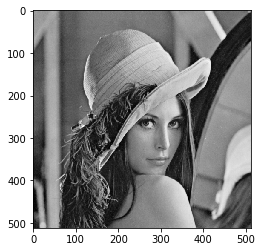

In [4]:
im_original = np.array(Image.open('./lena.png').convert("L"))
plt.imshow(im_original, cmap='gray')
im = torch.from_numpy(im_original.astype(np.float32)).clone()
im = im.unsqueeze(0).unsqueeze(0)
print(im.shape)

In [5]:
dwt = dwt_init(im)
iwt = iwt_init(dwt)
print(dwt.shape, iwt.shape)

torch.Size([1, 4, 256, 256]) torch.Size([1, 1, 512, 512])


In [6]:
dwt = dwt.squeeze()
iwt = iwt.squeeze()
dwt = dwt.to('cpu').detach().numpy().copy()
iwt = iwt.to('cpu').detach().numpy().copy()
print(dwt.shape, iwt.shape)

(4, 256, 256) (512, 512)


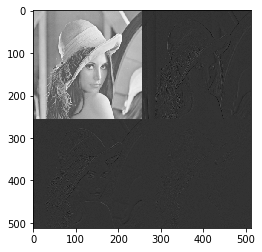

In [7]:
LL_LH = np.concatenate([dwt[0], dwt[1]], axis=1)
HL_HH = np.concatenate([dwt[2], dwt[3]], axis=1)
dwt_tiles = np.concatenate([LL_LH, HL_HH], axis=0)
plt.imshow(dwt_tiles, cmap='gray')

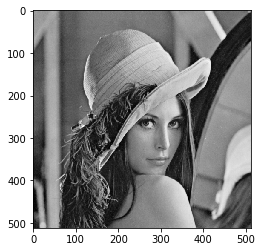

In [8]:
plt.imshow(iwt, cmap='gray')

In [9]:
all((im_original == iwt)[0])

True